In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to disable tensorflow warnings
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
audio_files = []
actors = os.listdir("archive")
for actor in actors:
    files = os.listdir("archive/"+actor)
    for file in files:
        audio_files.append("archive/"+actor+"/"+file)

print(audio_files)

['archive/Actor_15/03-01-06-02-01-02-15.wav', 'archive/Actor_15/03-01-08-02-01-01-15.wav', 'archive/Actor_15/03-01-04-01-02-02-15.wav', 'archive/Actor_15/03-01-06-02-02-02-15.wav', 'archive/Actor_15/03-01-03-01-01-01-15.wav', 'archive/Actor_15/03-01-05-01-02-01-15.wav', 'archive/Actor_15/03-01-07-01-02-01-15.wav', 'archive/Actor_15/03-01-07-01-01-02-15.wav', 'archive/Actor_15/03-01-04-02-02-02-15.wav', 'archive/Actor_15/03-01-07-02-01-01-15.wav', 'archive/Actor_15/03-01-03-02-01-01-15.wav', 'archive/Actor_15/03-01-01-01-01-01-15.wav', 'archive/Actor_15/03-01-08-01-02-02-15.wav', 'archive/Actor_15/03-01-05-02-02-02-15.wav', 'archive/Actor_15/03-01-06-02-02-01-15.wav', 'archive/Actor_15/03-01-08-01-01-01-15.wav', 'archive/Actor_15/03-01-04-01-01-02-15.wav', 'archive/Actor_15/03-01-06-02-01-01-15.wav', 'archive/Actor_15/03-01-03-01-02-01-15.wav', 'archive/Actor_15/03-01-06-01-01-01-15.wav', 'archive/Actor_15/03-01-03-02-02-01-15.wav', 'archive/Actor_15/03-01-02-01-01-01-15.wav', 'archive/

# Preparing my outputs
Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

So we have to make the outputs for each audio, it means we have to select only the emotion for each audio.

In [3]:
emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

# Processing the audio

In [4]:
def process_data(original_audio_file, sr=22050):
    
    audio_file = original_audio_file.copy()
    # We make sure our sound is 3.5 seconds before applying all the other functions on it
    if(len(audio_file) < int(sr*3.5)):
        audio_file = librosa.util.fix_length(audio_file, size=int(3.5*sr))
    
    mel_spec = librosa.feature.melspectrogram(y=audio_file, n_mels=256, sr=sr)
    mel_spectogram_db = librosa.power_to_db(mel_spec)
    # normalize the sample
    mel_spectogram_db = mel_spectogram_db.astype(np.float32)
    
    return mel_spectogram_db

# Data Augmentation

In [5]:
def add_noise(audio_file, noise_factor=0.005, sr=22050):

    noise = np.random.randn(len(audio_file))
    augmented_audio = audio_file + noise_factor * noise

    if(len(augmented_audio) < int(sr*3.5)):
        augmented_audio = librosa.util.fix_length(augmented_audio, size=int(3.5*sr))
    
    mel_spec = librosa.feature.melspectrogram(y=augmented_audio, n_mels=256, sr=sr)
    mel_spectogram_db = librosa.power_to_db(mel_spec)
    # normalize the sample
    mel_spectogram_db = mel_spectogram_db.astype(np.float32)
    
    return mel_spectogram_db

def pitch_shift(audio_file, pitch_factor=2, sr=22050):
    shifted_audio = librosa.effects.pitch_shift(audio_file, sr=sr, n_steps=pitch_factor)

    if(len(shifted_audio) < int(sr*3.5)):
        shifted_audio = librosa.util.fix_length(shifted_audio, size=int(3.5*sr))
    
    mel_spec = librosa.feature.melspectrogram(y=shifted_audio, n_mels=256, sr=sr)
    mel_spectogram_db = librosa.power_to_db(mel_spec)
    # normalize the sample
    mel_spectogram_db = mel_spectogram_db.astype(np.float32)
    
    return mel_spectogram_db



# Preparing my Data

In [6]:
def prepare_data(audio_files):
    X = []
    Y = []
    for audio in audio_files:
        audio_file, m = librosa.load(path=audio, sr=22050, duration=3.5)
        X.append(process_data(audio_file))
        X.append(add_noise(audio_file))
        X.append(pitch_shift(audio_file))

        label = int(audio.split("-")[2]) -1
        Y = Y + [label]*3

    return np.stack(X), np.array(Y)

X, Y = prepare_data(audio_files)

# Normalize the inputs
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# Shufffle the data

In [7]:
indices = np.arange(len(Y))
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]

# Viewing some examples

77989


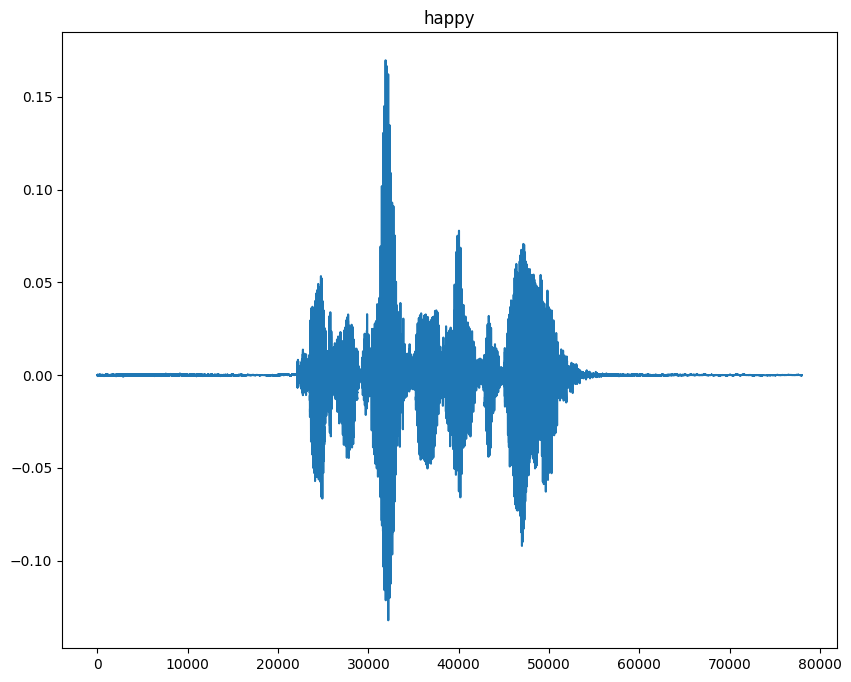

In [8]:
index = 80
emotion = emotions[int(audio_files[index].split("-")[2]) -1]

audio_file, m = librosa.load(audio_files[index], sr=22050)
print(len(audio_file))

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(audio_file)
plt.title(emotion)
plt.show()

# Viewing spectrograms and melspectrograms

Text(0.5, 1.0, 'happy')

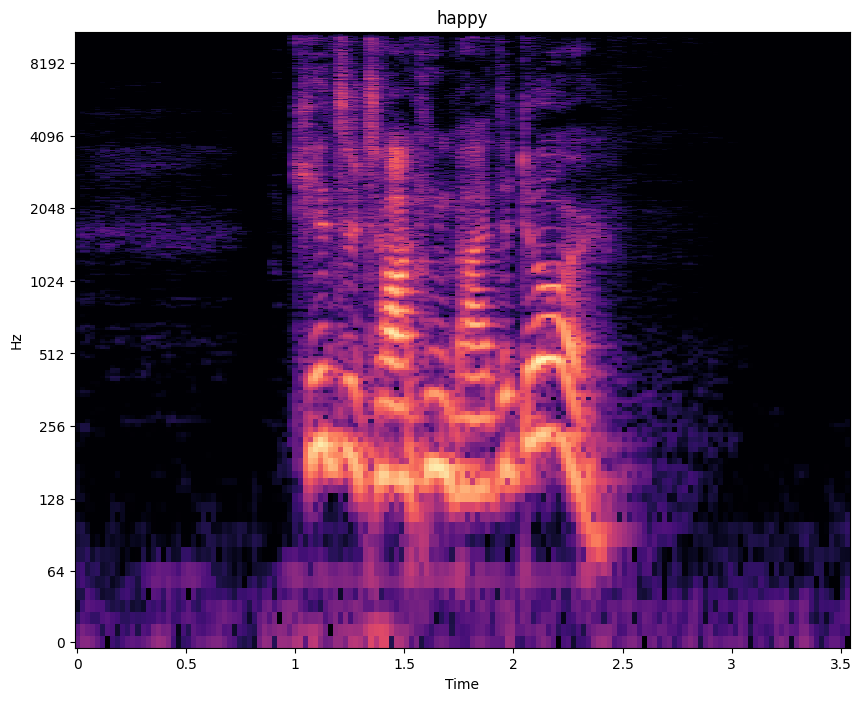

In [9]:
# We apply short time fourier transform
audio_file_transformed = librosa.stft(audio_file)
# We make the spectogram
spectogram = np.abs(audio_file_transformed)
spectogram_db = librosa.amplitude_to_db(spectogram)
fig, ax = plt.subplots(figsize=(10, 8))
sp = librosa.display.specshow(spectogram_db, x_axis="time", y_axis="log", ax=ax)
ax.set_title(emotion)

[[-41.816277 -35.993168 -38.565765 ... -42.96558  -44.598385 -42.741207]
 [-52.225204 -43.64885  -41.95536  ... -44.398003 -42.464336 -40.45754 ]
 [-54.050022 -48.95298  -41.219315 ... -50.761475 -46.0618   -42.049667]
 ...
 [-64.317856 -64.317856 -64.317856 ... -64.317856 -64.317856 -64.317856]
 [-64.317856 -64.317856 -64.317856 ... -64.317856 -64.317856 -64.317856]
 [-64.317856 -64.317856 -64.317856 ... -64.317856 -64.317856 -64.317856]]


Text(0.5, 1.0, 'happy melspectrogram')

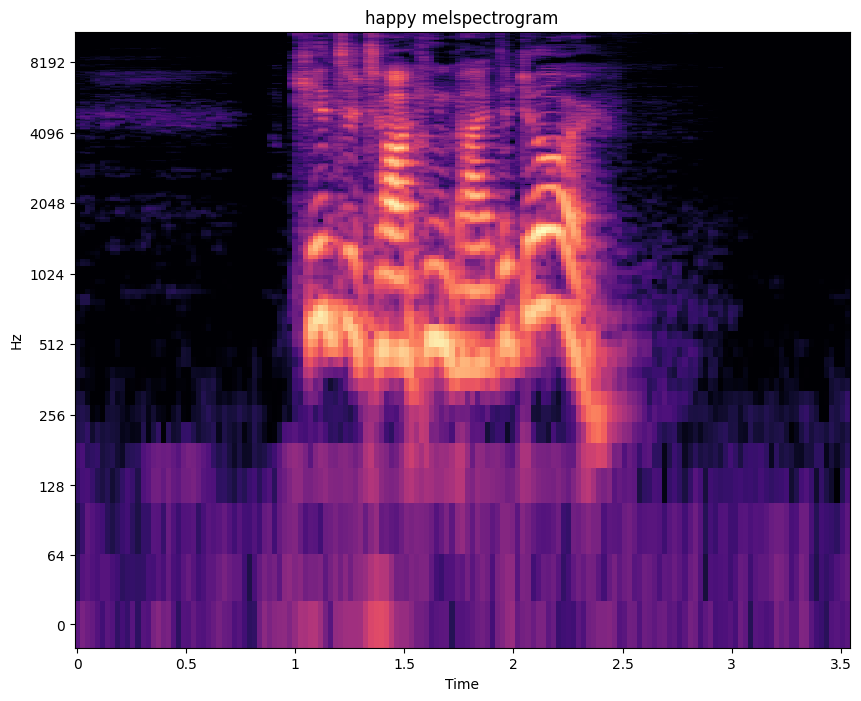

In [10]:
# mel spectrogram:
melspec = process_data(audio_file)
print(melspec)
fig, ax = plt.subplots(figsize=(10, 8))
sp = librosa.display.specshow(melspec, x_axis="time", y_axis="log", ax=ax)
ax.set_title(emotion + " melspectrogram")

[[-35.492073 -28.116655 -29.709347 ... -29.191105 -30.819584 -38.174786]
 [-34.294567 -29.439884 -34.9971   ... -27.862038 -28.222307 -32.035507]
 [-34.693615 -30.221024 -29.74939  ... -30.749937 -32.191574 -31.825212]
 ...
 [-30.766153 -27.706436 -28.558039 ... -26.492365 -28.20438  -33.082268]
 [-32.78914  -30.70995  -30.066254 ... -28.431269 -29.354815 -31.859047]
 [-29.068174 -27.267012 -28.116045 ... -27.044699 -28.611977 -30.628967]]


Text(0.5, 1.0, 'happy melspectrogram with noise')

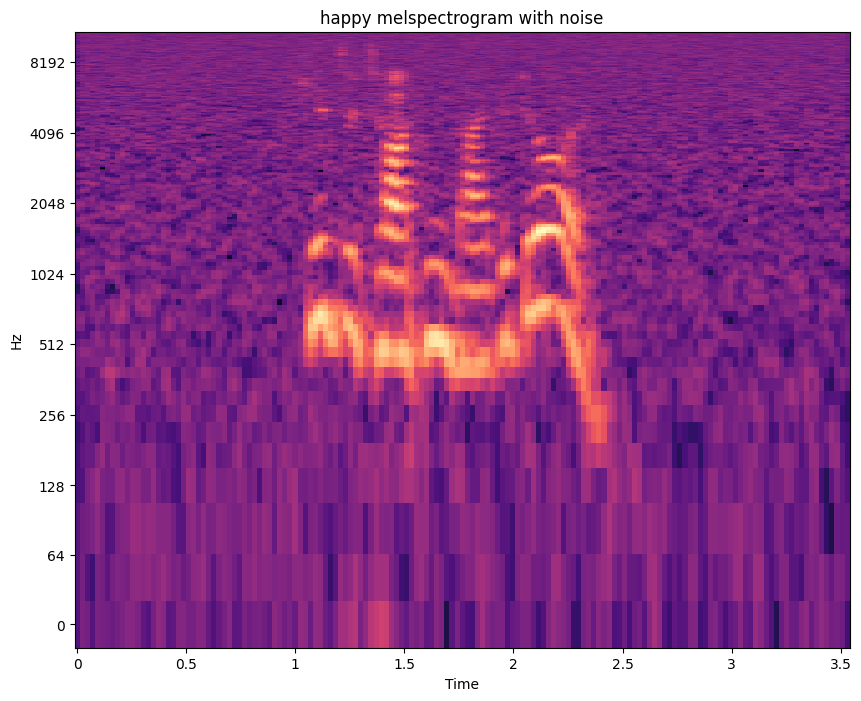

In [11]:
# Adding noise:
noise = add_noise(audio_file)
print(noise)
fig, ax = plt.subplots(figsize=(10, 8))
sp = librosa.display.specshow(noise, x_axis="time", y_axis="log", ax=ax)
ax.set_title(emotion + " melspectrogram with noise")

[[-41.44288  -35.95446  -38.209778 ... -45.556316 -45.769966 -50.71119 ]
 [-51.093475 -45.10028  -48.54772  ... -48.23436  -46.836224 -49.04943 ]
 [-55.197746 -52.28164  -51.43524  ... -50.70333  -50.80577  -48.58948 ]
 ...
 [-67.2076   -67.2076   -67.2076   ... -67.2076   -67.2076   -67.2076  ]
 [-67.2076   -67.2076   -67.2076   ... -67.2076   -67.2076   -67.2076  ]
 [-67.2076   -67.2076   -67.2076   ... -67.2076   -67.2076   -67.2076  ]]


Text(0.5, 1.0, 'happy melspectrogram shifted')

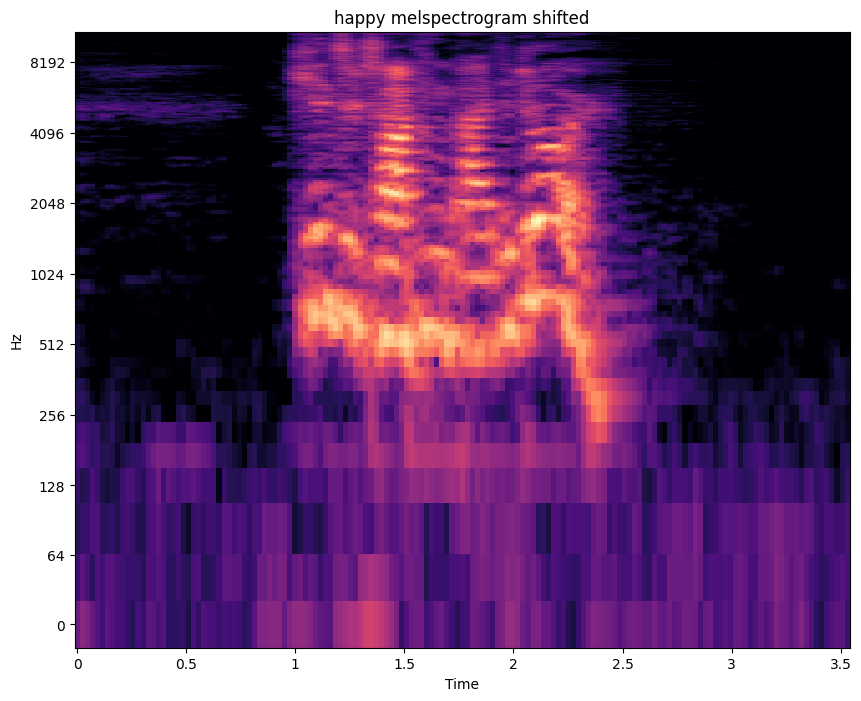

In [12]:
# Shifting:
shift = pitch_shift(audio_file)
print(shift)
fig, ax = plt.subplots(figsize=(10, 8))
sp = librosa.display.specshow(shift, x_axis="time", y_axis="log", ax=ax)
ax.set_title(emotion + " melspectrogram shifted")

# Split Data into data_train and data_test

In [13]:
# We are taking 80% for the training and 20% for testing
train_size = int(0.8*len(X))

X_train = X[:train_size]
Y_train = Y[:train_size]

X_test = X[train_size:]
Y_test = Y[train_size:]

# Creating Model

In [14]:
model = keras.Sequential()

model.add(keras.layers.Input(X.shape[1:] + (1,)))

model.add(keras.layers.Conv2D(32 , kernel_size=(3,3), activation="relu"))
model.add(keras.layers.AveragePooling2D(pool_size=(2,2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(64 , kernel_size=(3,3), activation="relu"))
model.add(keras.layers.AveragePooling2D(pool_size=(2,2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(keras.layers.AveragePooling2D(pool_size=(2,2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
model.add(keras.layers.AveragePooling2D(pool_size=(2,2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(8, activation='softmax'))
model.summary()

I0000 00:00:1761058837.560620   62109 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2600 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 149, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 127, 74, 32)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 74, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 74, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 72, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 62, 36, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 30, 17, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 14, 7, 256)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 7, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 7, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,03

 Total params: 1,204,072 (4.59 MB)

 Trainable params: 1,203,112 (4.59 MB)

 Non-trainable params: 960 (3.75 KB)

# Compiling the model

In [15]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

checkpoint = keras.callbacks.ModelCheckpoint(filepath="model.keras", monitor="val_accuracy", mode="max")

# Training the model

In [16]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=50, callbacks=checkpoint, validation_split=0.2)

test_scores = model.evaluate(X_test, Y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/50
 1/44 ━━━━━━━━━━━━━━━━━━━━ 13:49 19s/step - loss: 2.2026 - sparse_categorical_accuracy: 0.1094

I0000 00:00:1761058874.106767   62485 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 491ms/step - loss: 1.8518 - sparse_categorical_accuracy: 0.2648 - val_loss: 2.0780 - val_sparse_categorical_accuracy: 0.1286
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 1.5867 - sparse_categorical_accuracy: 0.4045 - val_loss: 2.1444 - val_sparse_categorical_accuracy: 0.1286
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 1.4336 - sparse_categorical_accuracy: 0.4631 - val_loss: 2.3125 - val_sparse_categorical_accuracy: 0.1286
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 1.3236 - sparse_categorical_accuracy: 0.5159 - val_loss: 2.4536 - val_sparse_categorical_accuracy: 0.1286
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 1.2075 - sparse_categorical_accuracy: 0.5492 - val_loss: 2.7920 - val_sparse_categorical_accuracy: 0.1286
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 1.0998 - sparse_categorical_accuracy: 0.5999 - val_loss: 2.9523 - val_sparse_categorical_accuracy: 0.1286
Epoch 7/50
44/

# Evaluating the model

In [17]:
test_scores = model.evaluate(X_test, Y_test, verbose=2)
print(test_scores)

27/27 - 1s - 22ms/step - loss: 0.5994 - sparse_categorical_accuracy: 0.8576
[0.5993848443031311, 0.8576388955116272]


85.76% of accuracy :)